In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, fbeta_score

## Load Data

In [2]:
# df = pd.read_excel("data/mr_pEF_HF_AI Chinese_with_answer.xlsx")
df = pd.read_csv("data/mr_pef_hf_wona_20220717.csv")
print("sample counts:", df.shape[0])
df.head(3)

sample counts: 6353


,id,death,age,sex,bmi,sbp,dbp,wbc_count,glucose_ac,bun,...,rwma,rwt_final,edv_final,esv_final,egfr_mdrd,rbbb_ecg,lbbb_ecg,lvh_ecg,q_wave_ecg,lv_strain_ecg
0,1,1,77,1,25.7117,150.0,80.0,4.8,135.0,22.0,...,0.0,0.39,97.83,33.59,81.8247,0.0,0.0,0.0,0.0,0.0
1,2,1,82,0,18.3111,137.0,69.0,6.5,167.0,26.0,...,0.0,0.46,87.69,29.55,95.7086,0.0,0.0,0.0,1.0,0.0
2,3,0,75,0,29.2381,111.0,58.0,5.6,141.0,10.0,...,0.0,0.48,65.11,19.13,69.9260,0.0,0.0,0.0,0.0,0.0


In [3]:
col_name_map = {'ID': 'ID', 'death': 'death'}
col_name_map.update({name: name.split('(')[0].rstrip() for name in df.columns if '(' in name})
df = df.rename(col_name_map, axis=1)
df.head(3)

,id,death,age,sex,bmi,sbp,dbp,wbc_count,glucose_ac,bun,...,rwma,rwt_final,edv_final,esv_final,egfr_mdrd,rbbb_ecg,lbbb_ecg,lvh_ecg,q_wave_ecg,lv_strain_ecg
0,1,1,77,1,25.7117,150.0,80.0,4.8,135.0,22.0,...,0.0,0.39,97.83,33.59,81.8247,0.0,0.0,0.0,0.0,0.0
1,2,1,82,0,18.3111,137.0,69.0,6.5,167.0,26.0,...,0.0,0.46,87.69,29.55,95.7086,0.0,0.0,0.0,1.0,0.0
2,3,0,75,0,29.2381,111.0,58.0,5.6,141.0,10.0,...,0.0,0.48,65.11,19.13,69.9260,0.0,0.0,0.0,0.0,0.0


In [4]:
df = df.drop(["id"], axis = 1)

## EDA

#### Basic information

In [5]:
df.info()
# feature皆為連續變數

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6353 entries, 0 to 6352
Data columns (total 58 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   death                  6353 non-null   int64  
 1   age                    6353 non-null   int64  
 2   sex                    6353 non-null   int64  
 3   bmi                    6353 non-null   float64
 4   sbp                    6353 non-null   float64
 5   dbp                    6353 non-null   float64
 6   wbc_count              6353 non-null   float64
 7   glucose_ac             6353 non-null   float64
 8   bun                    6353 non-null   float64
 9   uric_acid              6353 non-null   float64
 10  total_cholesterol      6353 non-null   float64
 11  triglyceride           6353 non-null   float64
 12  albumin                6353 non-null   float64
 13  alk_phosphatase        6353 non-null   float64
 14  sgot                   6353 non-null   float64
 15  sgpt

In [6]:
describe = df.describe()
unique = {col: len(df[col].unique()) for col in df.columns}
describe.at["unique"] = unique
describe.T
# feature皆為連續變數，但有些其實是類別(0、1)

,count,mean,std,min,25%,50%,75%,max,unique
death,6353.0,0.288368,0.453039,0.00000,0.0000,0.00000,1.00000,1.0000,2.0
age,6353.0,72.484653,13.696563,18.00000,64.0000,75.00000,82.00000,105.0000,84.0
sex,6353.0,0.433339,0.495575,0.00000,0.0000,0.00000,1.00000,1.0000,2.0
bmi,6353.0,25.126535,4.929949,11.41500,22.0000,24.55780,27.55100,59.5213,4286.0
sbp,6353.0,145.158705,27.437675,60.00000,126.0000,142.00000,161.00000,273.0000,186.0
dbp,6353.0,77.567606,15.630806,27.00000,68.0000,77.00000,86.00000,165.0000,116.0
wbc_count,6353.0,9.162177,4.089068,0.40000,6.4000,8.30000,11.00000,53.1000,268.0
glucose_ac,6353.0,160.004250,89.543949,15.00000,107.0000,133.00000,185.00000,2108.0000,453.0
bun,6353.0,27.401070,22.147818,1.00000,15.0000,20.00000,31.00000,261.0000,330.0
uric_acid,6353.0,7.203934,2.478038,0.90000,5.5000,6.90000,8.60000,22.4000,492.0


#### Checking the missing values

<AxesSubplot:>

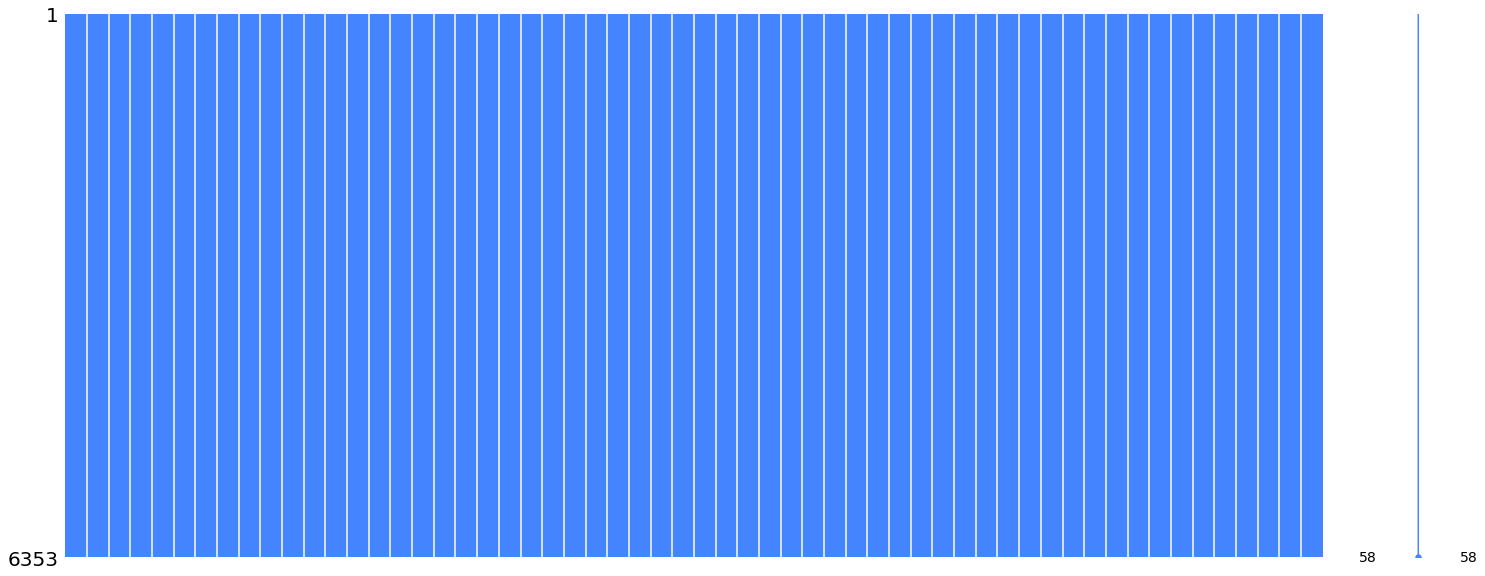

In [7]:
msno.matrix(df, color=(0.27, 0.52, 1.0))

<AxesSubplot:>

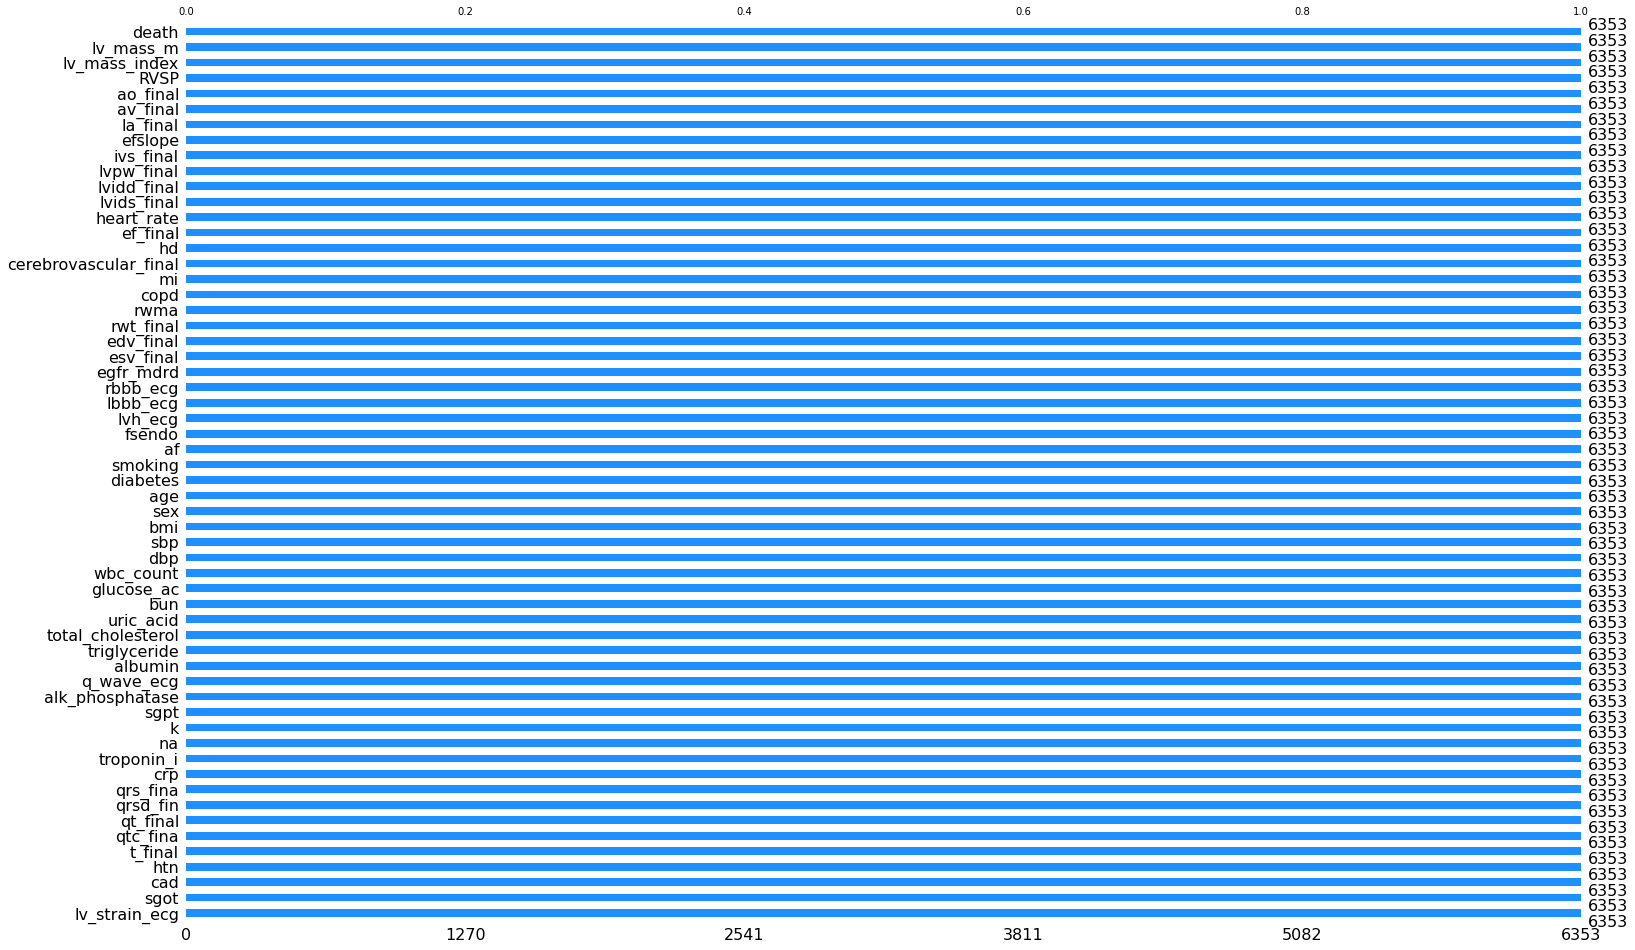

In [8]:
msno.bar(df, sort='descending', color="dodgerblue")

In [9]:
miss_col = df.columns[df.isnull().any(axis = 0)]
miss_sample = df[df.isnull().any(axis = 1)]
print(f"缺失值的欄數: {len(miss_col)}")
print(f"缺失值的樣本數: {len(miss_sample)}")
# miss_col

缺失值的欄數: 0
缺失值的樣本數: 0


In [10]:
df = df.dropna().reset_index(drop = True)

#### Find numerical and categorical variables

In [11]:
cat_col = []
for col in df.columns:
    if df[col].nunique() <= 20:
        # print(df[col].value_counts())
        cat_col.append(col)

num_col = list(set(df.columns) - set(cat_col))
print(f"category variables({len(cat_col)}) = \n {cat_col}\n")
print(f"numerical variables({len(num_col)}) = \n {num_col}")

category variables(17) = 
 ['death', 'sex', 'htn', 'cad', 'diabetes', 'smoking', 'af', 'hd', 'cerebrovascular_final', 'mi', 'copd', 'rwma', 'rbbb_ecg', 'lbbb_ecg', 'lvh_ecg', 'q_wave_ecg', 'lv_strain_ecg']

numerical variables(41) = 
 ['qrsd_fin', 'ivs_final', 'na', 'bmi', 'dbp', 'qtc_fina', 'lv_mass_m', 'sgot', 'albumin', 'ef_final', 'ao_final', 'RVSP', 'total_cholesterol', 'bun', 'lv_mass_index', 'efslope', 'alk_phosphatase', 'lvids_final', 'troponin_i', 'lvpw_final', 'sbp', 'wbc_count', 'heart_rate', 'lvidd_final', 'la_final', 'age', 'qrs_fina', 'rwt_final', 'triglyceride', 'crp', 'uric_acid', 'edv_final', 'fsendo', 'av_final', 'esv_final', 'egfr_mdrd', 'sgpt', 'qt_final', 'k', 't_final', 'glucose_ac']


#### Target Analysis

In [12]:
df["death"].value_counts()

0    4521
1    1832
Name: death, dtype: int64

In [13]:
#連續變數在target為死亡或存活時的平均值
for col in num_col:
    print(df.groupby("death").aggregate({col: "mean"}))
    print("-"*20)
# bun、total_cholesterol、egfr_mdrd、sgot、alk_phosphatase、triglyceride的死亡或存活之平均數差異較大

        qrsd_fin
death           
0      97.238443
1      98.093886
--------------------
       ivs_final
death           
0      10.642811
1      10.741921
--------------------
               na
death            
0      137.697744
1      136.863865
--------------------
             bmi
death           
0      25.571313
1      24.028913
--------------------
             dbp
death           
0      78.537514
1      75.174072
--------------------
         qtc_fina
death            
0      461.636585
1      460.606987
--------------------
        lv_mass_m
death            
0      167.599631
1      167.383270
--------------------
            sgot
death           
0      48.424242
1      56.007642
--------------------
        albumin
death          
0      3.542484
1      3.252789
--------------------
        ef_final
death           
0      59.721803
1      59.344580
--------------------
        ao_final
death           
0      31.867985
1      31.990775
--------------------
            R

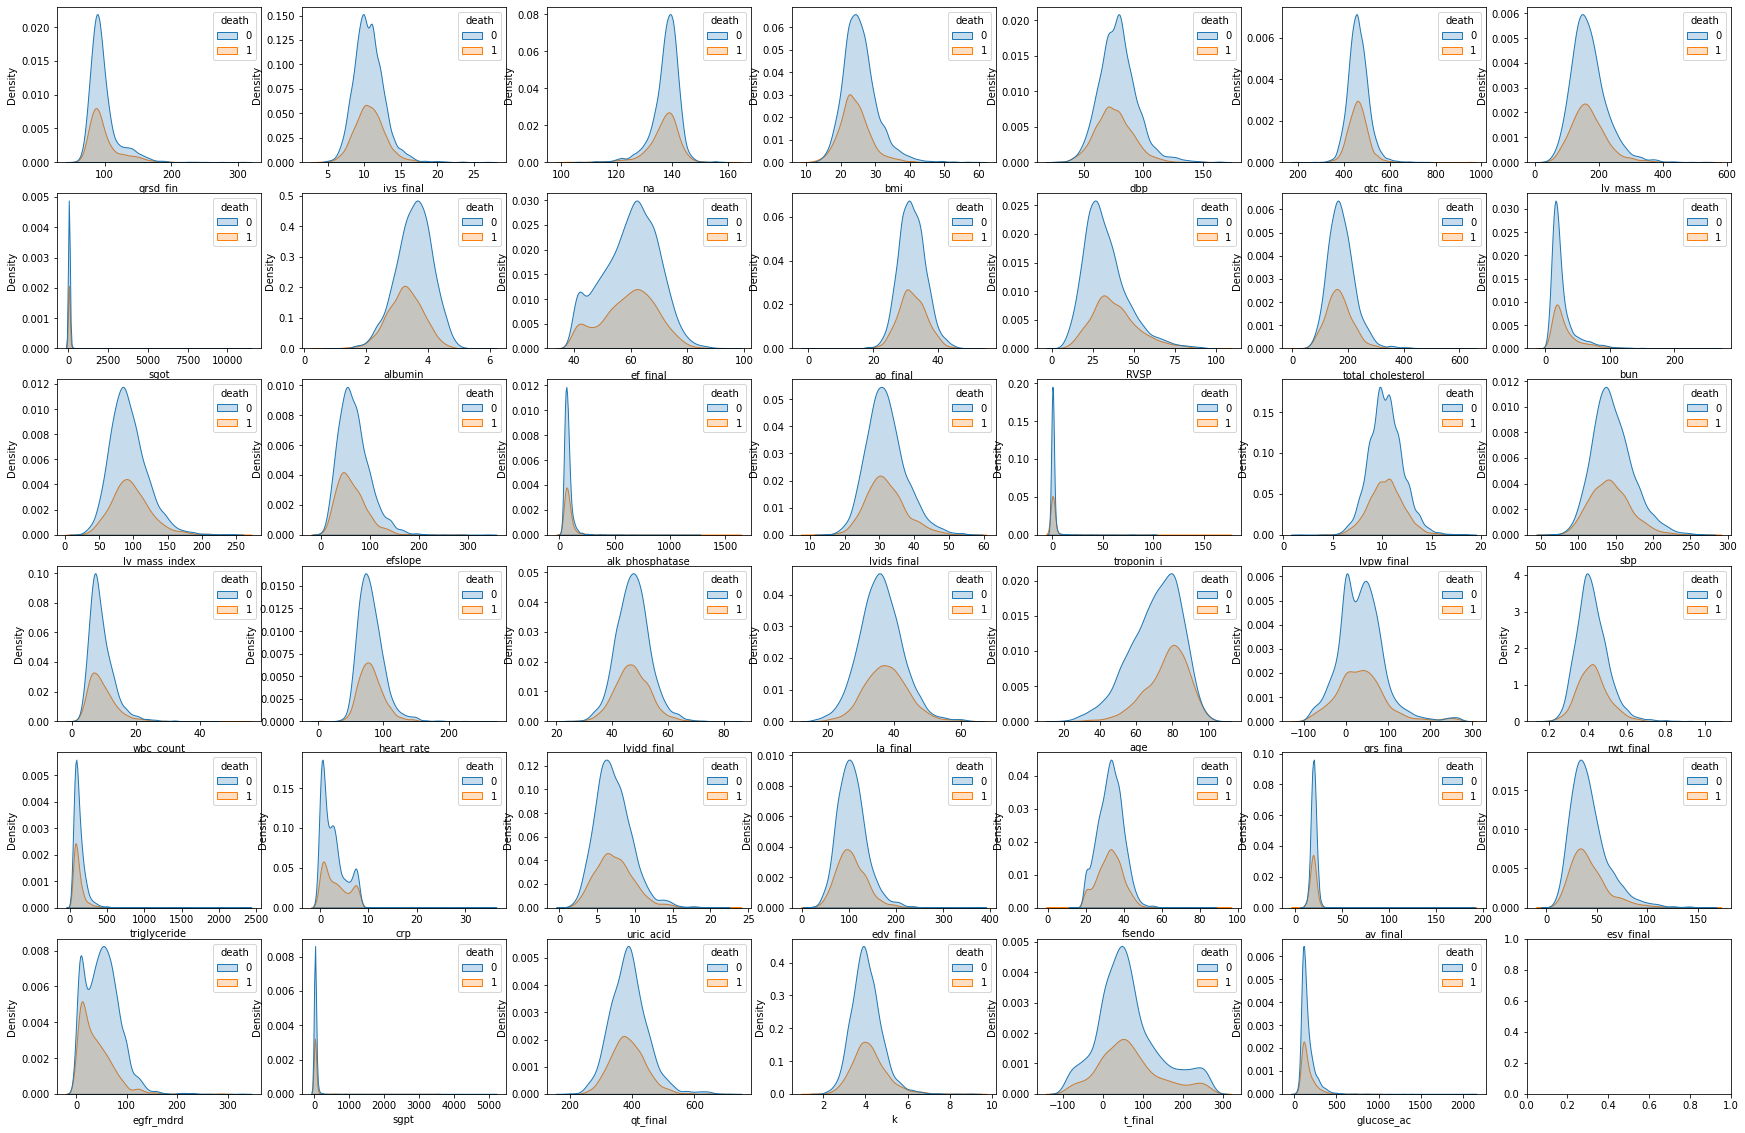

In [14]:
#連續變數在target為死亡或存活時的分布
a, b = 6, 7
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 20))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = df, x = num_col[k], hue = "death", shade=True, ax = ax[i, j])
        k += 1
        
        if k == len(num_col):
            break

#### Missing value double check

檢驗0是否代表nan

In [15]:
col_with_0 = (df[num_col] == 0).any(axis = 0)
col_with_0 = [num_col[i] for i, j in enumerate(col_with_0) if j]
col_with_0

['ao_final',
 'efslope',
 'troponin_i',
 'heart_rate',
 'qrs_fina',
 'av_final',
 't_final']

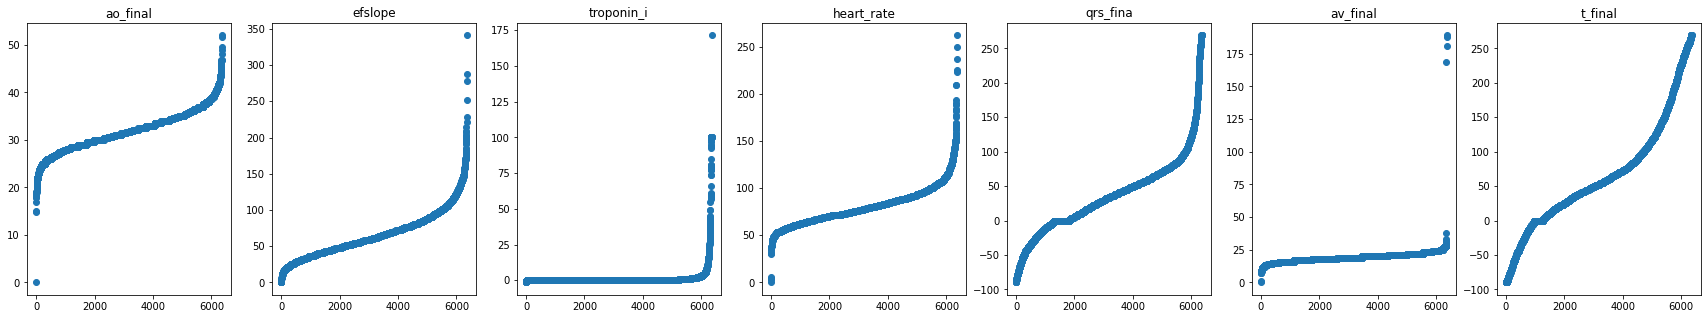

In [16]:
fig, ax = plt.subplots(1, 7, figsize=(30, 5))
for i in range(len(col_with_0)):
    ax[i].scatter(x = list(range(len(df))), y = sorted(df[col_with_0[i]]))
    ax[i].set_title(col_with_0[i])
# heart_rate、av_final、ao_final斷點之下可能為nan值
# troponin_i 數值需再做確認(有負值)

#### Outlier

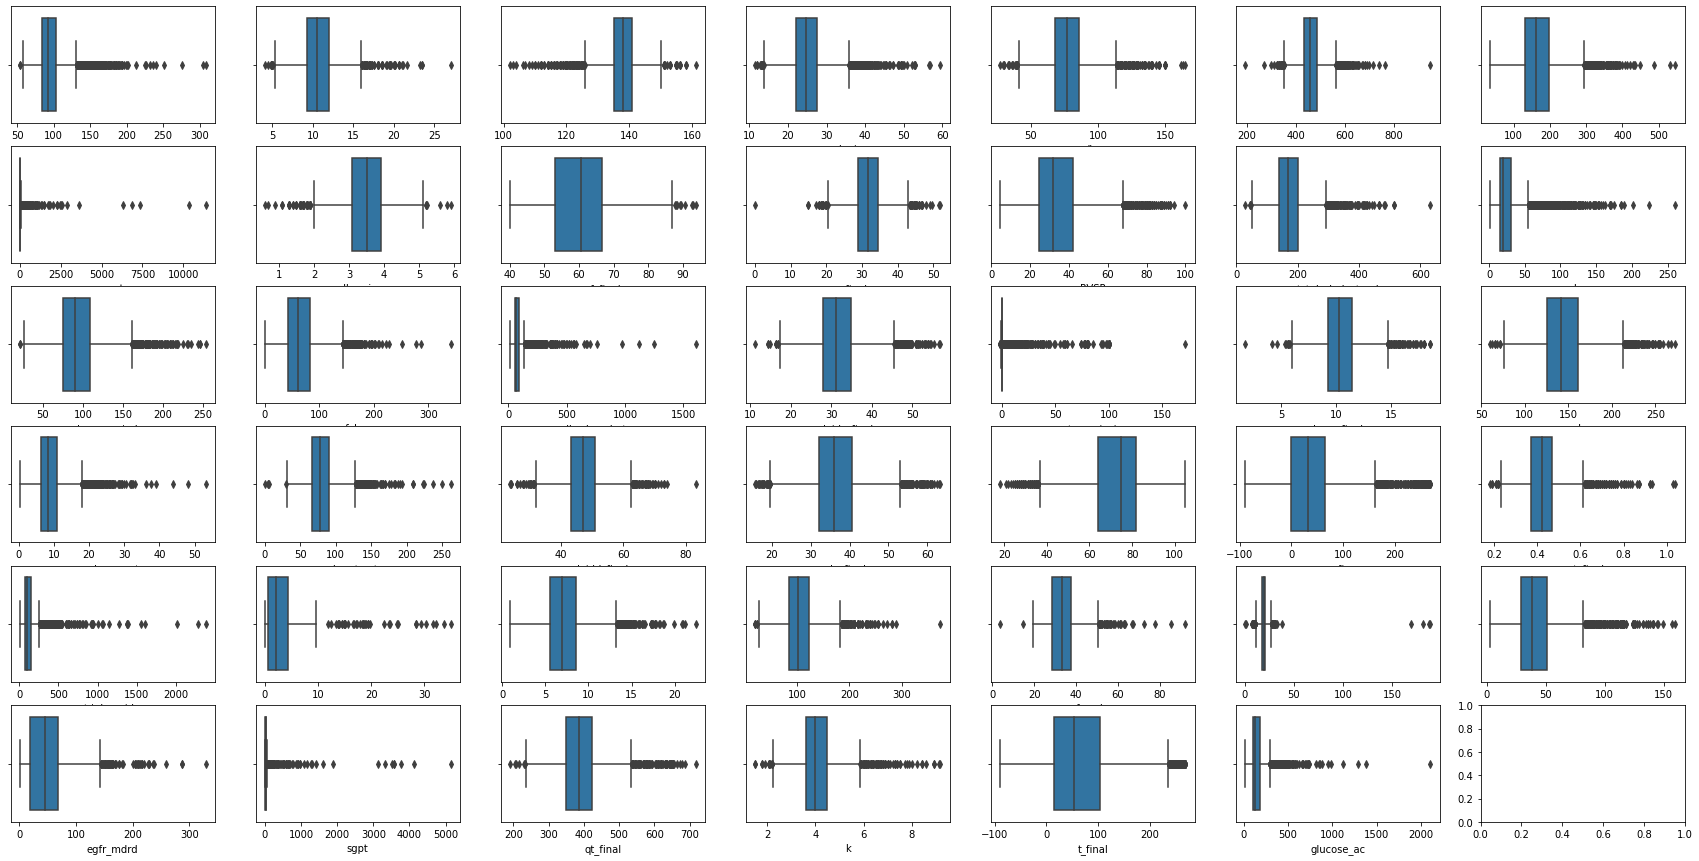

In [17]:
a, b = 6, 7
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 15))
for i in range(a):
    for j in range(b):
        sns.boxplot(x = num_col[k], data = df, ax = ax[i, j])
        k += 1
    
        if k == len(num_col):
            break

for col in num_col:
    Q1   = df[col].quantile(0.25)
    Q3   = df[col].quantile(0.75)
    IQR  = Q3 - Q1
    min_ = Q1 - (1.5 * IQR)
    max_ = Q3 + (1.5 * IQR)
    
    df[col] = df[col].apply(lambda X: max_ if X > max_ else X)
    df[col] = df[col].apply(lambda X: min_ if X < min_ else X)

#### Variable distribution

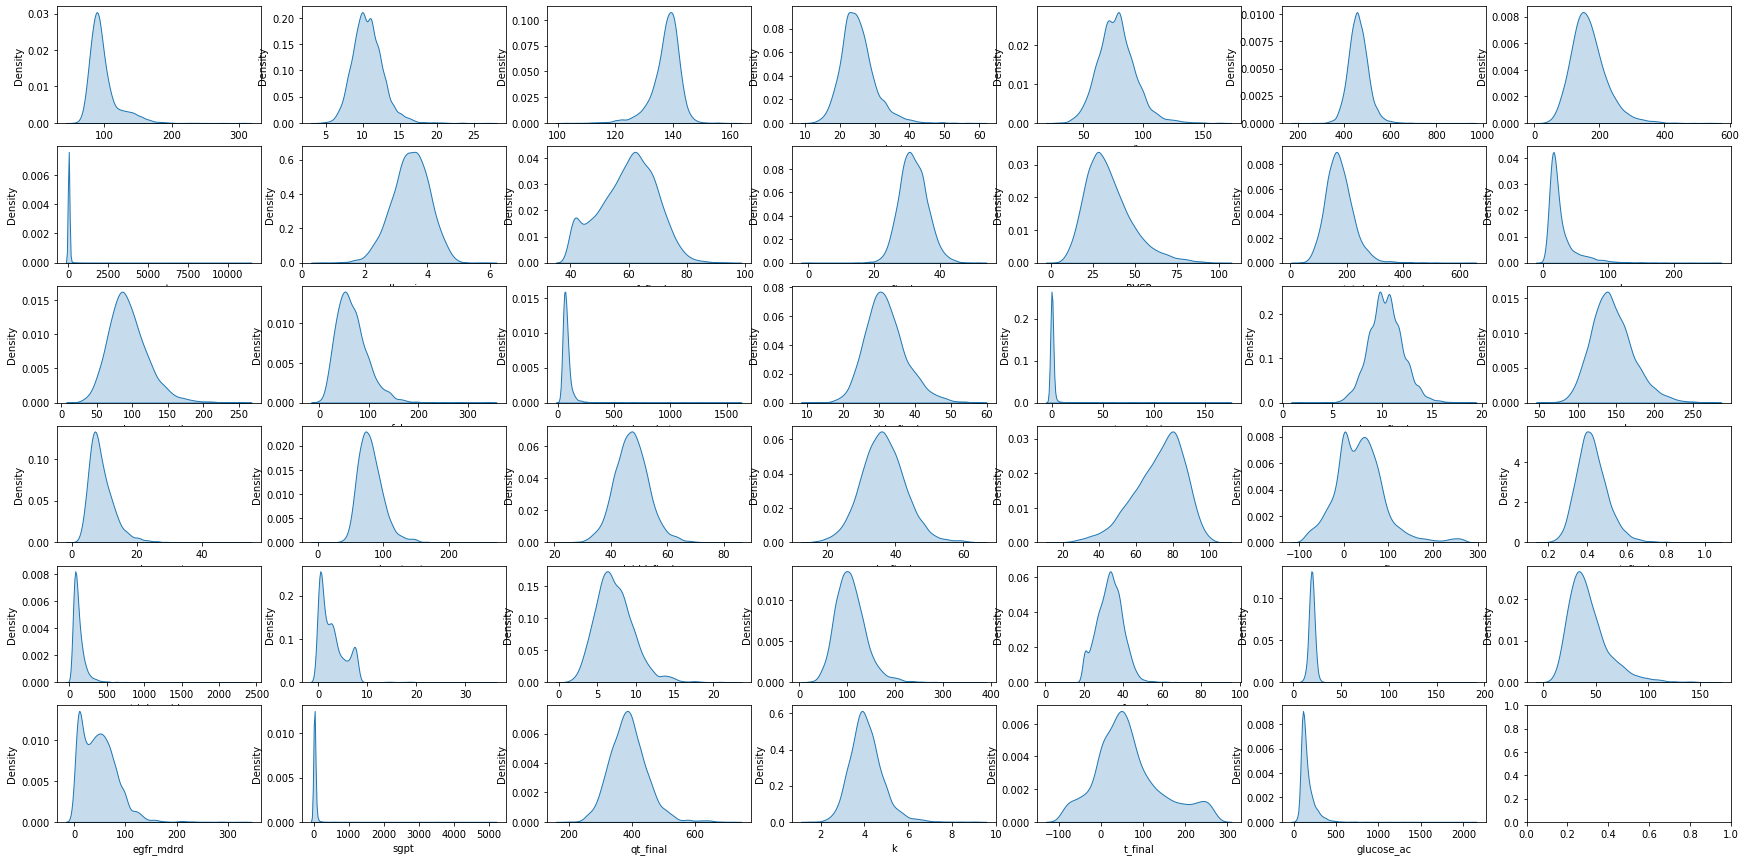

In [18]:
a, b = 6, 7
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 15))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = df, x = num_col[k], shade=True, ax = ax[i, j])
        # sns.histplot(data = df, x = num_col[k], kde=True, ax = ax[i, j])
        k += 1

        if k == len(num_col):
            break

#### Correlation

plt.figure(figsize=(30, 20))
sns.heatmap(data = df.corr(), annot=True, cmap = 'RdBu')

In [19]:
df_corr = df.corr()
df_corr = df_corr[abs(df_corr["death"]) > 0.1]
df_corr = df_corr[df_corr.index].round(2)

Text(0.5, 1.0, 'Features highly correlated with death (corr > 0.1 or corr < -0.1)')

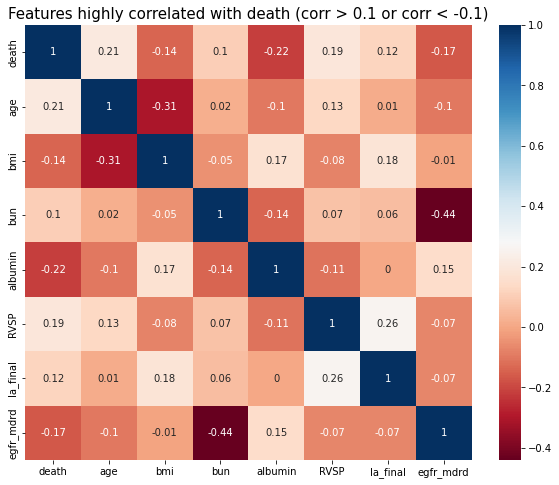

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(data = df_corr, annot=True, cmap = 'RdBu')
plt.title("Features highly correlated with death (corr > 0.1 or corr < -0.1)", fontsize = 15)

## Modeling

In [21]:
y = df["death"]
df = df.drop(["death", "troponin_i"], axis = 1)

#### Test Different Model

In [ ]:
df_rename = df.copy()
df_rename.columns = list(range(df.shape[1]))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_rename, random_state = 777, train_size = 0.8)
y_train = y.iloc[X_train.index]
y_test = y.iloc[X_test.index]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

random_state = 99#None
models = {
    "         Logistic Regression": LogisticRegression(),
    "      K Neighbors Classifier": KNeighborsClassifier(),
    "Support Vector Machine (SVC)": SVC(),
    "              MLP Classifier": MLPClassifier(),
    "    Decision Tree Classifier": DecisionTreeClassifier(),
    "    Random Forest Classifier": RandomForestClassifier(random_state = random_state),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "              XGB Classifier": XGBClassifier(random_state = random_state),
    "             LGBM Classifier": LGBMClassifier(random_state = random_state),
    "        Cat Boost Classifier": CatBoostClassifier(random_state = random_state),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    # print(name + " trained.")

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, fbeta_score

score = []
flag = 0
for model in models.values():
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)

    acc_train  = accuracy_score(y_train, pred_train).round(2)
    acc_test   = accuracy_score(y_test, pred_test).round(2)

    recall_train  = recall_score(y_train, pred_train).round(2)
    recall_test   = recall_score(y_test, pred_test).round(2)

    precision_train  = precision_score(y_train, pred_train).round(2)
    precision_test   = precision_score(y_test, pred_test).round(2)

    f1_train = f1_score(y_train, pred_train).round(2)
    f1_test = f1_score(y_test, pred_test).round(2)

    if flag == 1:
        col1 = [acc_train, acc_test, recall_train, recall_test, precision_train, precision_test, f1_train, f1_test]
        col2 = ["Accuracy_train", "Accuracy_test", "Recall_train", "Recall_test", "Precision_train", "Precision_test", "f1_train", "f1_test"]
    else:
        col1 = [acc_test, recall_test, precision_test, f1_test]
        col2 = ["Accuracy", "Recall", "Precision", "f1"]
    score.append(col1)

index  = [i.lstrip() for i in models.keys()]
score  = pd.DataFrame(score, index = index, columns = col2)
score

#### Model with K-fold

In [22]:
from functools import partial
f_score = partial(fbeta_score, beta=5)
params = { 'booster': 'gbtree', 
            # 'objective': custom_se, # 'multi:softmax' 多分類的問題 
            # 'objective': custom_asymmetric_objective, # 'multi:softmax' 多分類的問題 
            # 'num_class': 10, # 類別數，與 multisoftmax 並用 
            'n_estimators': 7000,
            'metric': f_score,
            'eval_metric': f_score,
            # 'gamma': 0.1, # 用於控制是否後剪枝的引數,越大越保守，一般0.1、0.2這樣子。 
            'max_depth': 3, # 構建樹的深度，越大越容易過擬合 
            'reg_lambda': 0.01, # 控制模型複雜度的權重值的L2正則化項引數，引數越大，模型越不容易過擬合。 
            'subsample': 0.7, # 隨機取樣訓練樣本 
            'colsample_bytree': 0.7, # 生成樹時進行的列取樣 
            'min_child_weight': 3, 
            'verbosity': 0, # 設定成1則沒有執行資訊輸出，最好是設定為0. 
            'learning_rate': 0.01, # 如同學習率 
            # 'reg_alpha':0, # L1 正則項引數
            'seed': 1000, 
            'nthread': -1, # cpu 執行緒數 
            'scale_pos_weight': 4.1,
            }

In [23]:
recall = 0
best_model, best_train_idx, best_test_idx = None, None, None
kf = KFold(n_splits = 3, shuffle = True, random_state = 46)
for train_idx, valid_idx in kf.split(df):
    X_train = df.iloc[train_idx]
    X_valid = df.iloc[valid_idx]
    y_train = y.iloc[train_idx]
    y_valid = y.iloc[valid_idx]

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_valid)

    train_acc = accuracy_score(y_train, pred_train)
    valid_acc = accuracy_score(y_valid, pred_valid)
    valid_recall = recall_score(y_valid, pred_valid)
    train_cm = confusion_matrix(y_train, pred_train)
    valid_cm = confusion_matrix(y_valid, pred_valid)

    print(f"train_accuracy: {train_acc}")
    # print(f"\ntrain Confusion Matrix:\n {train_cm}")
    print(f"\nValid Confusion Matrix:\n {valid_cm}")
    print(f"\nValid Classification Report:\n {classification_report(y_valid, pred_valid)}")
    print("{:-^70}".format(""))

    if valid_recall > recall:
        best_model = model
        best_train_idx = train_idx
        best_valid_idx = valid_idx
        recall = valid_recall

train_accuracy: 0.9865407319952775

Valid Confusion Matrix:
 [[1285  210]
 [ 133  490]]

Valid Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88      1495
           1       0.70      0.79      0.74       623

    accuracy                           0.84      2118
   macro avg       0.80      0.82      0.81      2118
weighted avg       0.85      0.84      0.84      2118

----------------------------------------------------------------------
train_accuracy: 0.9841794569067296

Valid Confusion Matrix:
 [[1276  235]
 [ 114  493]]

Valid Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      1511
           1       0.68      0.81      0.74       607

    accuracy                           0.84      2118
   macro avg       0.80      0.83      0.81      2118
weighted avg       0.85      0.84      0.84      2118

-------------------------------------

Text(0.5, 1.0, 'Feature Importances')

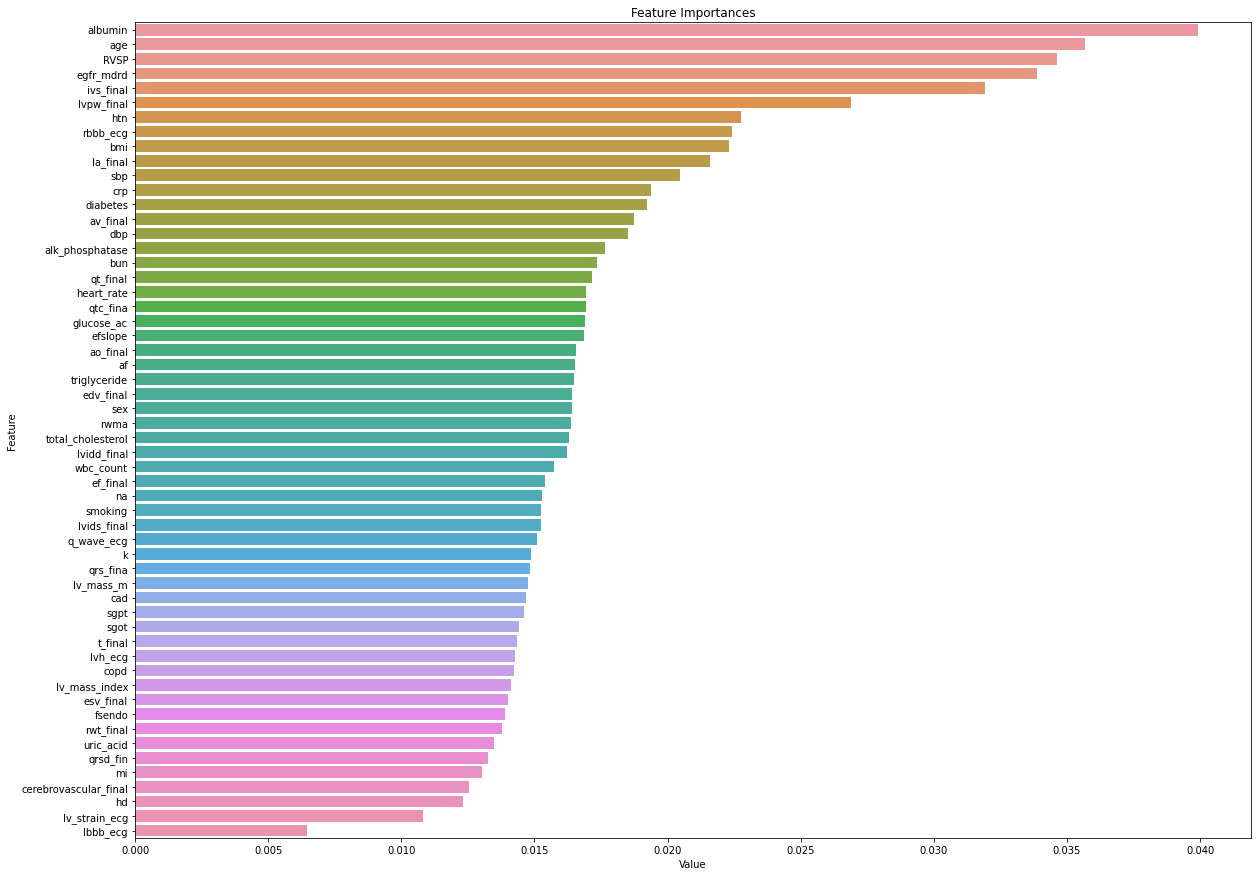

In [24]:
feature_imp = pd.DataFrame(zip(X_valid.columns, best_model.feature_importances_), columns = ["Feature", "Value"])
feature_imp = feature_imp.sort_values(by = "Value", ascending = False)
feature_imp = feature_imp.drop(feature_imp.query("Value == 0").index)

plt.figure(figsize=(20, 15))
sns.barplot(x = "Value", y = "Feature", data = feature_imp)
plt.title("Feature Importances")

## Risk segmentation

In [25]:
# 計算shap value
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(df)

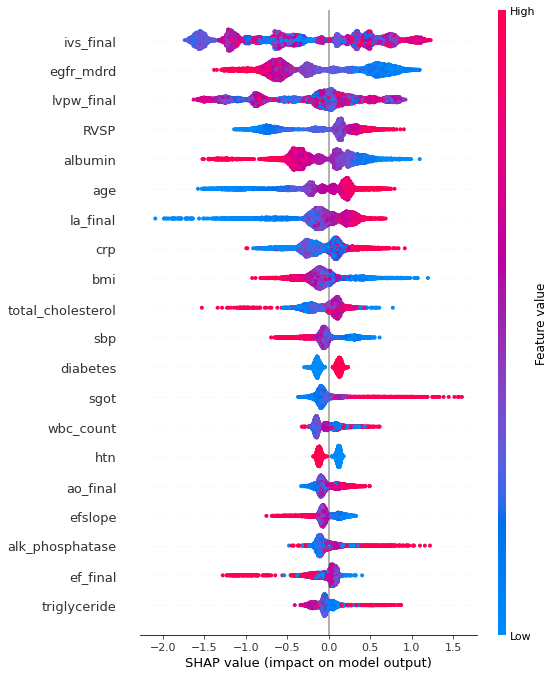

In [26]:
shap.summary_plot(shap_values, df)

In [27]:
# 第i個sample的force_plot的f(x)值 = 第i個sample的shap value加總 + base value(constant)
result_df = pd.DataFrame(shap_values.sum(axis=1) + explainer.expected_value, columns=['shap'])
result_df['true'] = y.reset_index(drop = True)
result_df

,shap,true
0,1.503825,1
1,1.685173,1
2,-1.109364,0
3,1.493278,1
4,1.715761,1
...,...,...
6348,-1.103757,1
6349,-2.642750,0
6350,-2.090069,0
6351,-1.330652,0


In [28]:
# 產生可能的風險切分點
train_df = result_df.iloc[best_train_idx].reset_index(drop=True)
valid_df = result_df.iloc[best_valid_idx].reset_index(drop=True)
threshold_list = np.linspace(train_df["shap"].min(), train_df["shap"].max(), 100) #在min和max之間產生100個點
threshold_adj = threshold_list[10:-10]

In [29]:
# 透過training data來找出最佳的切分點
# 低、中、高風險，需切兩刀
score = 0
best = []
total_died = train_df["true"].sum()
total_alive = len(train_df) - total_died
for idx, thres1 in enumerate(threshold_adj):
    for thres2 in threshold_adj[idx+1:]:
        low_df = train_df.query("shap <= @thres1")
        mid_df = train_df.query("(shap > @thres1) & (shap < @thres2)")
        high_df = train_df.query("shap >= @thres2")

        recall = high_df["true"].sum() / total_died #實際是高風險，且預期是高風險  #TP/(TP+FN) = Sensitivity
        specificity = (low_df.eval("true == 0").sum() + mid_df.eval("true == 0").sum()) / total_alive #實際是低風險，且預期是低風險  #TN/(FP+TN)
        # specificity = (1 - (low_df["true"].sum()) / total_alive)

        precision = high_df["true"].sum() / len(high_df) #預期是高風險，且實際上是高風險  #TP/(TP+FP)
        npv = low_df.eval("true == 0").sum() / len(low_df) #預期是低風險，且實際上是低風險  #TN/(FN+TN)

        current_score = npv * specificity * precision * recall
        if current_score > score and len(low_df) > len(train_df)/4:
        #     print(f'threshold={thres1:.3f} & {thres2:.3f}: {recall:.3f}, {specificity:.3f}, {precision:.3f}, {npv:.3f}, {current_score:.3f}')
            score = current_score
            best = (thres1, thres2, recall, specificity, precision, npv)

thres1, thres2, npv, specificity, precision, recall = best
best

(-2.665440463056468,
 0.7932590234159216,
 0.996734693877551,
 0.9970099667774086,
 0.9926829268292683,
 1.0)

In [30]:
# 評估找出的最佳切分點是否適用於所有data
def cut(df, thres1, thres2):
    # Confusion matrix
    hr_df = pd.DataFrame(columns=['Low', 'Mid', 'High'], index=['Dead', 'Alive'])
    low_df = df.query("shap <= @thres1")
    mid_df = df.query("(shap > @thres1) & (shap < @thres2)")
    high_df = df.query("shap >= @thres2")

    hr_df.at['Dead'] = [low_df["true"].sum(), mid_df["true"].sum(), high_df["true"].sum()]
    hr_df.at['Total'] = [len(low_df), len(mid_df), len(high_df)]
    hr_df.at['Alive'] = hr_df.loc['Total'] - hr_df.loc['Dead']
    hr_df['Total'] = hr_df.sum(axis=1).astype(int)
    
    # Classification Report
    total_died = df["true"].sum()
    total_alive = len(df) - total_died
    score_df = pd.DataFrame(columns=['Precision', 'Recall'], index=['Dead', 'Alive'])

    recall = high_df["true"].sum() / total_died #實際是高風險，且預期是高風險  #TP/(TP+FN)
    specificity = (low_df.eval("true == 0").sum() + mid_df.eval("true == 0").sum()) / total_alive #實際是低風險，且預期是低風險  #TN/(FP+TN)
    # specificity = (1 - (low_df["true"].sum()) / total_alive)

    precision = high_df["true"].sum() / len(high_df) #預期是高風險，且實際上是高風險  #TP/(TP+FP)
    npv = low_df.eval("true == 0").sum() / len(low_df) #預期是低風險，且實際上是低風險  #TN/(FN+TN)
    
    score_df["Precision"] = [precision, npv]
    score_df["Recall"] = [recall, specificity]

    print(f'''
npv: {npv}
precision: {precision}
specificity: {specificity}
recall: {recall}
          ''')
    
    return hr_df, score_df

In [31]:
hr_df, score_df = cut(result_df, thres1, thres2)
hr_df


npv: 0.9955214331413947
precision: 0.9334480780263913
specificity: 0.9743419597434196
recall: 0.8881004366812227
          


,Low,Mid,High,Total
Dead,7,198,1627,1832
Alive,1556,2849,116,4521
Total,1563,3047,1743,6353


In [32]:
score_df

,Precision,Recall
Dead,0.933448,0.888100
Alive,0.995521,0.974342


In [33]:
hr_df, score_df = cut(valid_df, thres1, thres2)
hr_df


npv: 0.984304932735426
precision: 0.7914230019493177
specificity: 0.9291859695565851
recall: 0.6688632619439868
          


,Low,Mid,High,Total
Dead,7,194,406,607
Alive,439,965,107,1511
Total,446,1159,513,2118


In [34]:
score_df

,Precision,Recall
Dead,0.791423,0.668863
Alive,0.984305,0.929186


In [35]:
# 低風險
i = 0
shap.force_plot(explainer.expected_value, shap_values[i, :], df.iloc[i, :])

In [36]:
# 高風險
i = 2
shap.force_plot(explainer.expected_value, shap_values[i, :], df.iloc[i, :])

#### Save risk data

In [37]:
low_df = result_df.query("shap <= @thres1")
mid_df = result_df.query("(shap > @thres1) & (shap < @thres2)")
high_df = result_df.query("shap >= @thres2")

In [38]:
df1 = pd.read_csv("data/mr_pef_hf_wona_20220717.csv")
df1.loc[low_df.index, "Risk"] = "Low"
df1.loc[mid_df.index, "Risk"] = "Medium"
df1.loc[high_df.index, "Risk"] = "High"

df1.to_csv("data/mr_pef_hf_risk.csv", index = False)